<a href="https://colab.research.google.com/github/supabhay/stock-price-prediction-lstm/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [7]:
df= pd.read_csv("/content/sopra_steria_10yr.csv")
df.head()

,date,open,high,low,Last,close,total trade quantity,turnover (millions)
0,27-06-2014,66.690893,66.690893,65.756779,66.264809,66.264809,9296,0.615998
1,30-06-2014,66.289377,66.289377,64.765295,65.412621,65.412621,44182,2.890060
2,01-07-2014,65.551919,65.756768,63.847567,64.421150,64.421150,16191,1.043043
3,02-07-2014,65.134036,65.134036,64.044240,64.486710,64.486710,18118,1.168370
4,03-07-2014,65.074478,65.309585,64.285186,65.074478,65.074478,26654,1.734495


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2561 entries, 2014-06-27 to 2024-06-26
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  2561 non-null   datetime64[ns]
 1   open                  2561 non-null   float64       
 2   high                  2561 non-null   float64       
 3   low                   2561 non-null   float64       
 4   Last                  2561 non-null   float64       
 5   close                 2561 non-null   float64       
 6   total trade quantity  2561 non-null   int64         
 7   turnover (millions)   2561 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 180.1 KB


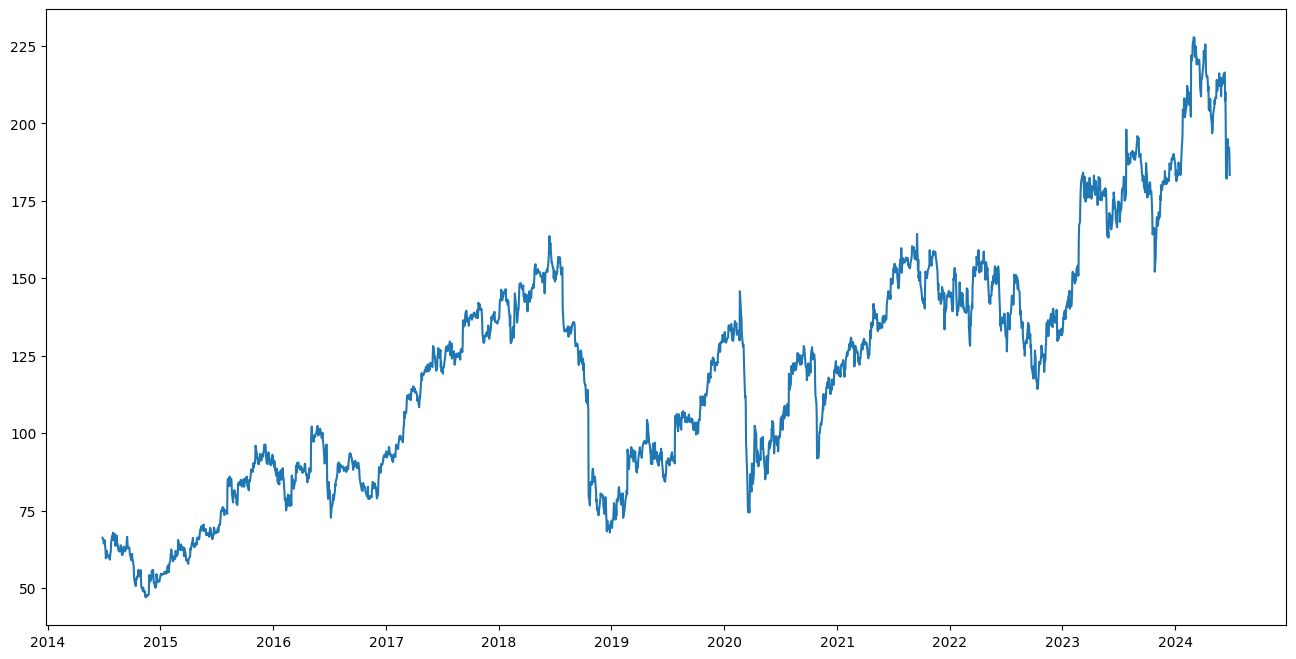

In [14]:
df["date"]=pd.to_datetime(df.date,format="%d-%m-%Y")
df.index=df['date']

plt.figure(figsize=(16,8))
plt.plot(df["close"],label='Close Price history')

In [51]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['date','close'])
new_dataset = data[['date','close']].reset_index(drop=True)

In [52]:
print(new_dataset.columns)

new_dataset.index = new_dataset['date']
new_dataset.drop("date", axis=1, inplace=True)

#splitting before scaling to prevent data leakage
train_data = new_dataset[:987]
valid_data = new_dataset[987:]

#scale only on train data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data)

x_train_data, y_train_data = [], []

for i in range(60, len(scaled_train_data)):
  x_train_data.append(scaled_train_data[i-60:i, 0])
  y_train_data.append(scaled_train_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))


Index(['date', 'close'], dtype='object')


In [53]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=150))
lstm_model.add(Dense(1))

inputs_data=new_dataset [len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data,y_train_data, epochs=5, batch_size=2,verbose=2)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


464/464 - 38s - 83ms/step - loss: 0.0035
Epoch 2/5
464/464 - 42s - 90ms/step - loss: 0.0012
Epoch 3/5
464/464 - 40s - 87ms/step - loss: 9.3783e-04
Epoch 4/5
464/464 - 41s - 88ms/step - loss: 8.0537e-04
Epoch 5/5
464/464 - 40s - 87ms/step - loss: 6.8137e-04


In [56]:
X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i, 0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step


In [57]:
lstm_model.save("saved_model.h5")

/tmp/ipython-input-59-3219570390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


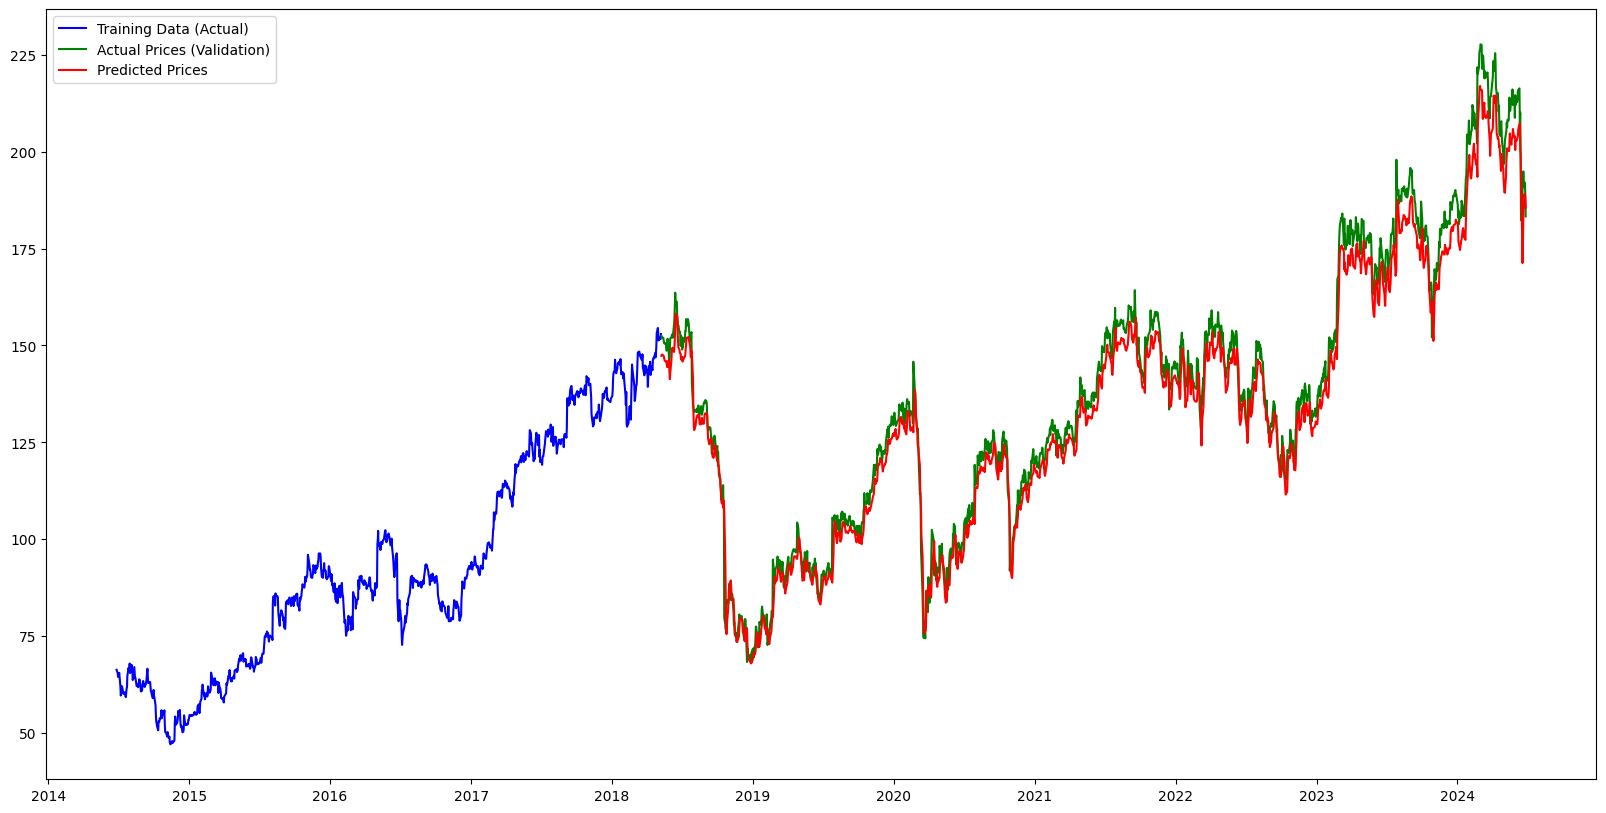

In [59]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["close"], label="Training Data (Actual)", color='blue')
plt.plot(valid_data["close"], label="Actual Prices (Validation)", color='green')
plt.plot(valid_data["Predictions"], label="Predicted Prices", color='red')
plt.legend()